In [144]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [17]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [8]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)



In [10]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
# Measurement
measurement = Base.classes.measurement

#station
station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [18]:
# Explore Database - measurement
inspector = inspect(engine)
inspector.get_table_names()

# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])



id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [19]:
# Explore Database - station
inspector = inspect(engine)
inspector.get_table_names()

# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])



id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [22]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

In [51]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_ago

# Perform a query to retrieve the data and precipitation scores
percipitation = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date > year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(percipitation, columns=['Date', 'Percipitation'])

# Sort the dataframe by date
df.sort_values(by=['Date'])


,Date,Percipitation
0,2016-08-24,0.08
1006,2016-08-24,NaN
1524,2016-08-24,2.15
702,2016-08-24,2.28
360,2016-08-24,2.15
...,...,...
1522,2017-08-22,0.00
1523,2017-08-23,0.08
359,2017-08-23,0.00
1005,2017-08-23,0.00


Text(0, 0.5, 'Inches')

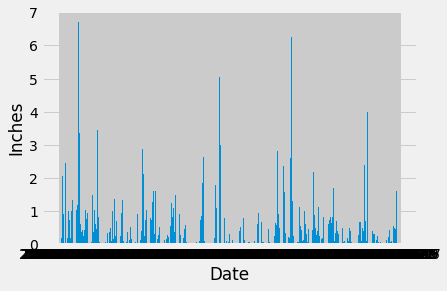

In [166]:
# Use Pandas Plotting with Matplotlib to plot the data

plt.bar(df["Date"], df["Percipitation"])
plt.xlabel("Date")
plt.ylabel("Inches")

In [53]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Percipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [60]:
#Viewing Data
session.query(station.id, station.station,station.name,station.latitude,station.longitude,station.elevation).order_by(station.id.asc()).all()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [92]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(station.station)).all()


[(9,)]

In [119]:
count = session.query(func.count(measurement.station)).\
    group_by(measurement.station).count()
print(f'There are {count} stations in the dataset.')

There are 9 stations in the dataset.


In [84]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
engine.execute('SELECT station, COUNT(station) FROM measurement GROUP BY station ORDER BY COUNT(station) DESC').fetchall()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [106]:
most_active = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
most_active = most_active[0][0]
print(f'The most active station was {most_active}')

'USC00519281'

In [121]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.round(func.avg(measurement.tobs), 1)).\
    filter(measurement.station == most_active).all()
temp = temp[0]
print(f"{most_active} station's lowest Temperature was {temp[0]}")
print(f"{most_active} stations high Temperature was {temp[1]}")
print(f"{most_active} stations average Temperature was {temp[2]}")

USC00519281 station's lowest Temperature was 54.0
USC00519281 stations high Temperature was 85.0
USC00519281 stations average Temperature was 71.7


In [127]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 
temp = session.query(measurement.tobs).\
    filter(measurement.date > year_ago).\
    filter(measurement.station == most_active).all()
temp

[(77.0,),
 (80.0,),
 (80.0,),
 (75.0,),
 (73.0,),
 (78.0,),
 (77.0,),
 (78.0,),
 (80.0,),
 (80.0,),
 (78.0,),
 (78.0,),
 (78.0,),
 (73.0,),
 (74.0,),
 (80.0,),
 (79.0,),
 (77.0,),
 (80.0,),
 (76.0,),
 (79.0,),
 (75.0,),
 (79.0,),
 (78.0,),
 (79.0,),
 (78.0,),
 (78.0,),
 (76.0,),
 (74.0,),
 (77.0,),
 (78.0,),
 (79.0,),
 (79.0,),
 (77.0,),
 (80.0,),
 (78.0,),
 (78.0,),
 (78.0,),
 (77.0,),
 (79.0,),
 (79.0,),
 (79.0,),
 (79.0,),
 (75.0,),
 (76.0,),
 (73.0,),
 (72.0,),
 (71.0,),
 (77.0,),
 (79.0,),
 (78.0,),
 (79.0,),
 (77.0,),
 (79.0,),
 (77.0,),
 (78.0,),
 (78.0,),
 (78.0,),
 (78.0,),
 (77.0,),
 (74.0,),
 (75.0,),
 (76.0,),
 (73.0,),
 (76.0,),
 (74.0,),
 (77.0,),
 (76.0,),
 (76.0,),
 (74.0,),
 (75.0,),
 (75.0,),
 (75.0,),
 (75.0,),
 (71.0,),
 (63.0,),
 (70.0,),
 (68.0,),
 (67.0,),
 (77.0,),
 (74.0,),
 (77.0,),
 (76.0,),
 (76.0,),
 (75.0,),
 (76.0,),
 (75.0,),
 (73.0,),
 (75.0,),
 (73.0,),
 (75.0,),
 (74.0,),
 (75.0,),
 (74.0,),
 (75.0,),
 (73.0,),
 (75.0,),
 (73.0,),
 (73.0,),
 (74.0,),


In [128]:
# Save the query results as a Pandas DataFrame
temp_df = pd.DataFrame(temp, columns=['Temperature'])


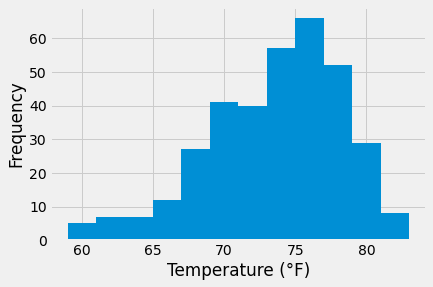

In [130]:
# Plot the results as a histogram
plt.hist(temp_df, bins=12)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()

# Close session

In [167]:
# Close Session
session.close()